In [1]:
from datetime import datetime
import backtrader as bt
import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])



# 创建策略类
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=2  # 移动平均期数
                  )

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.datas[0].close, period=self.params.period)

    def next(self):
        # self.log('value %.2f' % self.broker.getvalue())
        if not self.position.size:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.datas[0].close[-1] < self.move_average.sma[
                    -1] and self.datas[0].close[0] > self.move_average.sma[0]:
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.datas[0].close[-1] > self.move_average.sma[-1] and self.datas[
                0].close[0] < self.move_average.sma[0]:
            self.sell(size=100)


##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()

# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, '600000qfq.csv')
datapath = '600000qfq.csv'

# 创建行情数据对象，加载数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2019, 3, 1),  # 起始日
    todate=datetime(2020, 5, 1))  # 结束日

cerebro.adddata(data)  # 将行情数据对象注入引擎
cerebro.addstrategy(SmaCross)  # 将策略注入引擎
cerebro.broker.setcash(10000.0)  # 设置初始资金

# Analyzer
# 这个是含kelly和其他更多指标的定制分析者
# cerebro.addanalyzer(bt.analyzers.BasicTradeStats, _name='basicstats')
cerebro.addanalyzer(bt.analyzers.Kelly, _name='kelly')


# cerebro.addwriter(bt.WriterFile, csv=True, out='mywriter.csv', rounding=2)
thestrats = cerebro.run()
thestrat = thestrats[0]

print('kelly:', thestrat.analyzers.kelly.get_analysis())

# 打印各个分析器内容
for a in thestrat.analyzers:
    a.print()


kelly: AutoOrderedDict([('kellyRatio', 0.025), ('kellyPercent', '2.5 %')])
Kelly:
  - kellyRatio: 0.025
  - kellyPercent: 2.5 %


2019-04-01T23:59:59.999989, BUY CREATE, 10.98
2019-04-01T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-04-01T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-04-09T23:59:59.999989, BUY EXPIRED
2019-04-30T23:59:59.999989, BUY CREATE, 11.49
2019-04-30T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-04-30T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-05-06T23:59:59.999989, BUY EXECUTED, Price: 11.40, Cost: 11.40, Comm 0.00
2019-05-08T23:59:59.999989, SELL CREATE, 11.16
2019-05-08T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-05-08T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-05-09T23:59:59.999989, SELL EXECUTED, Price: 11.13, Cost: 11.40, Comm 0.00
2019-05-28T23:59:59.999989, BUY CREATE, 10.84
2019-05-28T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-05-28T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-05-29T23:59:59.999989, BUY EXECUTED, Price: 10.83, Cost: 10.83, Comm 0.00
2019-05-29T23:59:59.999989, SELL CREATE, 10.79
2019-05-29T23:59:59.999989, ORDER ACCEPTED/SUBMITTED
2019-05-29T23

<IPython.core.display.Javascript object>


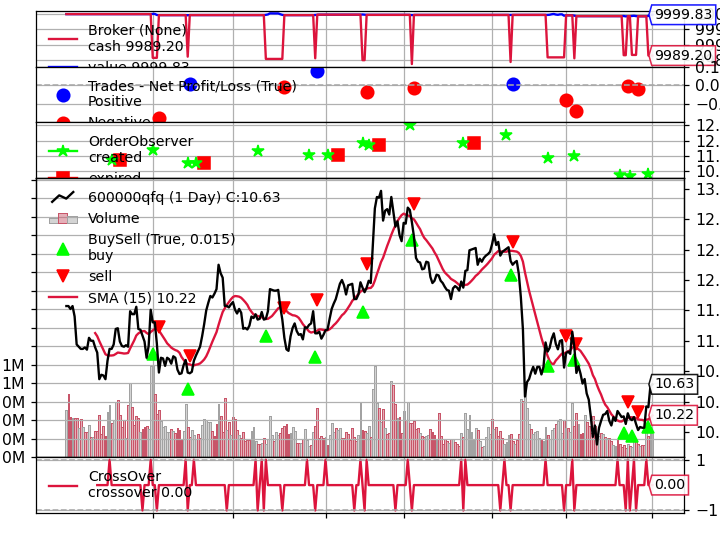

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime
import os.path  # 管理路径
import sys  # 发现脚本名字
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind

from backtrader.observers.orderobserver import OrderObserver


class MyStrategy(bt.Strategy):
    params = (
        ('smaperiod', 15),
        ('limitperc', 1.0),
        ('valid', 7),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('ORDER ACCEPTED/SUBMITTED', dt=order.created.dt)
            self.order = order
            return

        if order.status in [order.Expired]:
            self.log('BUY EXPIRED')

        elif order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,
                          order.executed.comm))

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,
                          order.executed.comm))

        # Set to None: new orders allowed
        self.order = None

    def __init__(self):
        # SimpleMovingAverage on main data
        sma = btind.SMA(period=self.p.smaperiod)

        # CrossOver (1: up, -1: down) close / sma
        self.crossover = btind.CrossOver(self.data.close, sma, plot=True)

        # Set to None: new ordersa allowed
        self.order = None

    def next(self):
        if self.order:
            # 有未决订单，跳过
            return

        # Check if we are in the market
        if self.position:
            if self.crossover < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()

        elif self.crossover > 0:
            plimit = self.data.close[0] * (1.0 - self.p.limitperc / 100.0)
            valid = self.data.datetime.datetime(0) + \
                datetime.timedelta(days=self.p.valid)
            self.log('BUY CREATE, %.2f' % plimit)
            self.order = self.buy(
                exectype=bt.Order.Limit, price=plimit, valid=valid)


def runstrat():
    cerebro = bt.Cerebro()

    # 获取本脚本文件所在路径
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    # 拼接得到数据文件全路径
#     datapath = os.path.join(modpath, './600000qfq.csv')
    datapath = '600000qfq.csv'
    # 创建行情数据对象，加载数据
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        datetime=2,  # 日期行所在列
        open=3,  # 开盘价所在列
        high=4,  # 最高价所在列
        low=5,  # 最低价所在列
        close=6,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        openinterest=-1,  # 无未平仓量列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime.datetime(2019, 3, 1),  # 起始日
        todate=datetime.datetime(2020, 5, 1))  # 结束日

    cerebro.adddata(data)  # 将行情数据对象注入引擎

    cerebro.addobserver(OrderObserver)

    cerebro.addstrategy(MyStrategy)
    cerebro.run()

    cerebro.plot()


if __name__ == '__main__':
    runstrat()

          date    open    high     low   close      volume  outstanding_share   
0   2018-01-02  153.97  155.92  153.85  155.31  31323053.0       2.810376e+10  \
1   2018-01-03  155.44  156.29  154.58  154.58  37839101.0       2.810376e+10   
2   2018-01-04  155.07  155.44  154.09  154.58  27883804.0       2.810376e+10   
3   2018-01-05  154.70  155.19  154.09  154.95  31026744.0       2.810376e+10   
4   2018-01-08  154.95  155.19  154.22  154.83  31389887.0       2.810376e+10   
..         ...     ...     ...     ...     ...         ...                ...   
482 2019-12-25  156.36  156.36  155.22  155.73  13678175.0       2.810376e+10   
483 2019-12-26  155.98  156.74  155.60  156.36  15739054.0       2.810376e+10   
484 2019-12-27  155.85  158.14  155.85  156.74  27932109.0       2.810376e+10   
485 2019-12-30  156.11  157.25  154.20  157.00  41051555.0       2.810376e+10   
486 2019-12-31  156.74  157.51  155.34  157.38  31953628.0       2.810376e+10   

     turnover  
0    0.0011

<IPython.core.display.Javascript object>


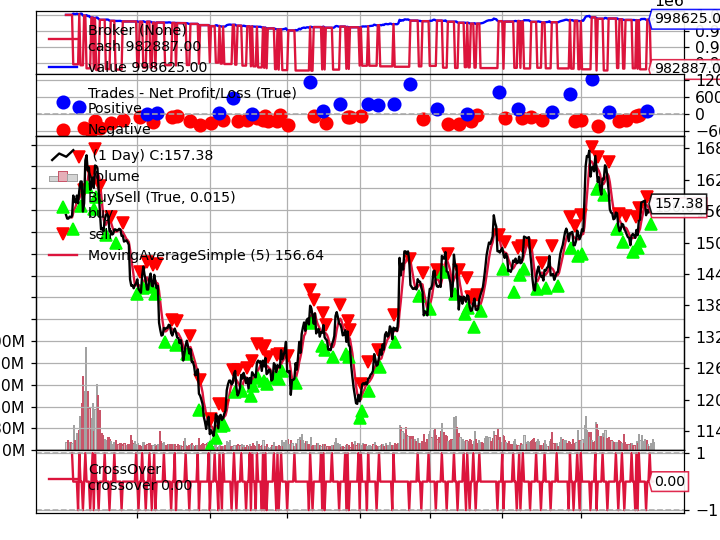

[[<Figure size 640x480 with 5 Axes>]]

In [3]:
import backtrader as bt
import akshare as ak



# 创建策略类
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=5  # 移动平均期数
                  )

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行, %.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单 Canceled/Margin/Rejected')



    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                  (trade.pnl, trade.pnlcomm, trade.commission))

    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.data, period=self.params.period)

        # 交叉信号指标
        self.crossover = bt.ind.CrossOver(self.data, self.move_average)

    def next(self):

        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.crossover > 0:
                self.log('创建买单')
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.crossover < 0:
            self.log('创建卖单')
            self.sell(size=100)

##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()

# start_date = datetime(2018, 1, 1)  # 回测开始时间
# end_date = datetime(2020, 1, 1)  # 回测结束时间

 # 利用 AkShare 获取后复权数据
stock_hfq_df = ak.stock_zh_a_daily(symbol="sh600000", adjust="hfq",start_date='20180101',end_date='20200101') 

print(stock_hfq_df)

data = bt.feeds.PandasData(
 dataname=stock_hfq_df,
 datetime=0, # 日期所在列
 open=1, # 开盘价所在列
 high=2, # 最高价所在列
 low=3, # 最低价所在列
 close=4, # 收盘价价所在列
 volume=5, # 成交量所在列
 openinterest=-1, # 无未平仓量列.(openinterest是期货交易使用的)
)


cerebro.adddata(data)  # 将数据传入回测系统
cerebro.addstrategy(SmaCross)  # 将交易策略加载到回测系统中
cerebro.broker.setcash(1000000.0)  # 设置初始资金



cerebro.run()  # 运行
print('最终市值: %.2f' % cerebro.broker.getvalue())

cerebro.plot()  # 画图

In [6]:
from datetime import datetime
import backtrader as bt
#import backtrader.analyzers.basictradestats as bts
import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])


# 创建策略类
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=5)  # 移动平均期数

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return
        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行, %.2f' % order.executed.price)
            elif order.issell():
                self.log('卖单执行, %.2f' % order.executed.price)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单 Canceled/Margin/Rejected')

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                  (trade.pnl, trade.pnlcomm, trade.commission))

    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.data, period=self.params.period)
        # 交叉信号指标
        self.crossover = bt.ind.CrossOver(self.data, self.move_average)

    def next(self):
        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.crossover > 0:
                self.log('创建买单 len %d' % len(self))
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.crossover < 0:
            self.log('创建卖单  len %d' % len(self))
            self.sell(size=100)


##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()
# 原始的BuySell观察者买卖价格有误，所以这里新加一个BuySell观察者，其买卖价格是正确的。
cerebro.addobserver(bt.observers.BuySell) 
# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000qfq.csv')
datapath = '600000qfq.csv'
# 创建行情数据对象，加载数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2019, 3, 1),  # 起始日
    todate=datetime(2020, 5, 1))  # 结束日

cerebro.adddata(data)  # 将行情数据对象注入引擎
cerebro.addstrategy(SmaCross)  # 将策略注入引擎
cerebro.broker.setcash(10000.0)  # 设置初始资金

# Analyzer
cerebro.addanalyzer(
    bt.analyzers.SharpeRatio,
    riskfreerate=0.01,
    annualize=True,
    _name='sharp_ratio')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annula_return')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)

# cerebro.addwriter(bt.WriterFile, csv=True, out='mywriter.csv', rounding=2)
# cerebro.addwriter(bt.WriterFile, csv=True, out=sys.stdout, rounding=2)
cerebro.addwriter(bt.WriterFile, out='mywriter.csv', rounding=2)
cerebro.run()


2019-03-18, 创建买单 len 12
2019-03-19, 买单执行, 11.28
2019-03-21, 创建卖单  len 15
2019-03-22, 卖单执行, 11.14
毛收益 -13.58, 扣佣后收益 -13.58, 佣金 0.00
2019-03-29, 创建买单 len 21
2019-04-01, 买单执行, 11.02
2019-04-09, 创建卖单  len 27
2019-04-10, 卖单执行, 11.15
毛收益 13.57, 扣佣后收益  13.57, 佣金 0.00
2019-04-16, 创建买单 len 32
2019-04-17, 买单执行, 11.60
2019-04-22, 创建卖单  len 36
2019-04-23, 卖单执行, 11.33
毛收益 -27.16, 扣佣后收益 -27.16, 佣金 0.00
2019-04-30, 创建买单 len 42
2019-05-06, 买单执行, 11.40
2019-05-08, 创建卖单  len 45
2019-05-09, 卖单执行, 11.13
毛收益 -26.19, 扣佣后收益 -26.19, 佣金 0.00
2019-05-15, 创建买单 len 50
2019-05-16, 买单执行, 10.94
2019-05-17, 创建卖单  len 52
2019-05-20, 卖单执行, 10.94
毛收益 0.00, 扣佣后收益  0.00, 佣金 0.00
2019-05-20, 创建买单 len 53
2019-05-21, 买单执行, 10.99
2019-05-22, 创建卖单  len 55
2019-05-23, 卖单执行, 10.79
毛收益 -20.37, 扣佣后收益 -20.37, 佣金 0.00
2019-05-27, 创建买单 len 58
2019-05-28, 买单执行, 10.85
2019-05-29, 创建卖单  len 60
2019-05-30, 卖单执行, 10.84
毛收益 -0.97, 扣佣后收益 -0.97, 佣金 0.00
2019-06-03, 创建买单 len 63
2019-06-04, 买单执行, 10.95
2019-06-25, 创建卖单  len 78
2019-06-26, 卖单执行

初始市值: 10000.00
2019-01-11, 创建买单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-01-15, 买单执行, 9.80
trade
2019-01-22, 创建卖单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-01-23, 卖单执行, 9.98
trade
毛收益 18.43, 扣佣后收益  17.23, 佣金 1.20
2019-01-24, 创建买单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-01-25, 买单执行, 10.14
trade
2019-02-15, 创建卖单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-02-18, 卖单执行, 10.43
trade
毛收益 29.09, 扣佣后收益  27.84, 佣金 1.25
2019-02-18, 创建买单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-02-19, 买单执行, 10.52
trade
2019-03-07, 创建卖单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-03-08, 卖单执行, 11.37
trade
毛收益 84.38, 扣佣后收益  83.02, 佣金 1.36
2019-03-18, 创建买单
self.p.commission 0.0001
self.p.commission 0.0001
self.p.commission 0.0001
2019-03-19, 买单执行, 11.28
trade
2019-03-21, 创建卖单
self.p.commission

<IPython.core.display.Javascript object>


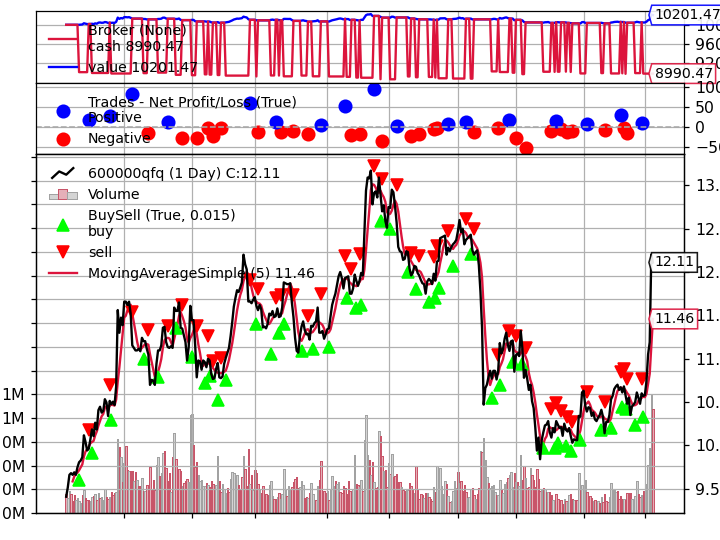

[[<Figure size 640x480 with 4 Axes>]]

In [13]:
from datetime import datetime
import backtrader as bt
import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])



class stampDutyCommissionScheme(bt.CommInfoBase):
    '''
    本佣金模式下，买入股票仅支付佣金，卖出股票支付佣金和印花税.    
    '''
    params = (
        ('stamp_duty', 0.005), # 印花税率
        ('commission', 0.001), # 佣金率
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        )
 
    def _getcommission(self, size, price, pseudoexec):
        '''
        If size is greater than 0, this indicates a long / buying of shares.
        If size is less than 0, it idicates a short / selling of shares.
        '''
        print('self.p.commission',self.p.commission)
        if size > 0: # 买入，不考虑印花税
            return  size * price * self.p.commission 
        elif size < 0: # 卖出，考虑印花税
            return - size * price * (self.p.stamp_duty + self.p.commission)
        else:
            return 0 #just in case for some reason the size is 0.


# 创建策略类
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=5  # 移动平均期数
                  )

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
      

    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.data, period=self.params.period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，处于未决订单状态。
            return

        # 订单已决，执行如下语句
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行, %.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected, order.Expired]:
            self.log('订单 Canceled/Margin/Rejected')



    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        print('trade')
        
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                     (trade.pnl, trade.pnlcomm, trade.commission))



    def next(self):
        
        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.data.close[
                    -1] < self.move_average[-1] and self.data > self.move_average:
                self.log('创建买单')
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.data.close[
                -1] > self.move_average[-1] and self.data < self.move_average:
            self.log('创建卖单')
            self.sell(size=100)


##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()


# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000qfq.csv')

datapath =   '600000qfq.csv'
# 创建行情数据对象，加载数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1, # 无未平仓量列
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2019, 1, 1),  # 起始日
    todate=datetime(2020, 7, 8))  # 结束日

cerebro.adddata(data)  # 将行情数据对象注入引擎
cerebro.addstrategy(SmaCross)  # 将策略注入引擎

cerebro.broker.setcash(10000.0)  # 设置初始资金
comminfo=stampDutyCommissionScheme(stamp_duty=0.001,commission=0.0001, percabs=True)
cerebro.broker.addcommissioninfo(comminfo)


print('初始市值: %.2f' % cerebro.broker.getvalue())
cerebro.run()  # 运行
print('最终市值: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from datetime import datetime  # 用于datetime对象操作
import os.path  # 用于管理路径
import sys  # 用于在argvTo[0]中找到脚本名称
import backtrader as bt  # 引入backtrader框架


# 创建策略
class SmaCross(bt.Strategy):
    # 可配置策略参数
    params = dict(
        pfast=5,  # 短期均线周期
        pslow=10  # 长期均线周期
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # 短期均线
        sma2 = bt.ind.SMA(period=self.p.pslow)  # 长期均线
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # 交叉信号

    def next(self):
        if not self.position:  # 不在场内，则可以买入
            if self.crossover > 0:  # 如果金叉
                self.buy(size=5000)  # 买入
        elif self.crossover < 0:  # 在场内，且死叉
            self.close()  # 卖出

    def stop(self):
        print('(Fast Period %3d, Slow Period %3d) Ending Value %.2f' %
              (self.p.pfast, self.p.pslow, self.broker.getvalue()))


if __name__ == '__main__':
    cerebro = bt.Cerebro()  # 创建cerebro

    # 获取本脚本文件所在路径
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    # 拼接得到数据文件全路径
#     datapath = os.path.join(modpath, './600000qfq.csv')
    datapath = '600000qfq.csv'
    # 创建行情数据对象，加载数据
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        datetime=2,  # 日期行所在列
        open=3,  # 开盘价所在列
        high=4,  # 最高价所在列
        low=5,  # 最低价所在列
        close=6,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime(2018, 1, 1),  # 起始日
        todate=datetime(2020, 7, 8))  # 结束日

    # 在Cerebro中添加价格数据
    cerebro.adddata(data)
    # 设置启动资金
    cerebro.broker.setcash(100000.0)

    # 设置佣金为千分之一
    cerebro.broker.setcommission(commission=0.001)

    # 添加策略
    cerebro.optstrategy(
        SmaCross, pfast=[5, 10, 15], pslow=[20, 30, 60])
    # cerebro.optstrategy(SmaCross, pfast=range(5,10), pslow=range(20,25))
    
    # 单线程串行优化，但只加载一次数据 
    cerebro.run(maxcpus=1, optdatas=True)


(Fast Period   5, Slow Period  20) Ending Value 108159.13
(Fast Period   5, Slow Period  30) Ending Value 102752.97
(Fast Period   5, Slow Period  60) Ending Value 105702.67
(Fast Period  10, Slow Period  20) Ending Value 111589.73
(Fast Period  10, Slow Period  30) Ending Value 98526.90
(Fast Period  10, Slow Period  60) Ending Value 103236.82
(Fast Period  15, Slow Period  20) Ending Value 76189.61
(Fast Period  15, Slow Period  30) Ending Value 93919.43
(Fast Period  15, Slow Period  60) Ending Value 95806.63


In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from datetime import datetime  # 用于datetime对象操作
import os.path  # 用于管理路径
import sys  # 用于在argvTo[0]中找到脚本名称
import backtrader as bt  # 引入backtrader框架


# 创建策略
class SmaCross(bt.Strategy):
    # 可配置策略参数
    params = dict(
        period=(5, 10),  # 元组，(短期均线周期,长期均线周期)
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.period[0])  # 短期均线
        sma2 = bt.ind.SMA(period=self.p.period[1])  # 长期均线
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # 交叉信号

    def next(self):
        if not self.position:  # 不在场内，则可以买入
            if self.crossover > 0:  # 如果金叉
                self.buy(size=5000)  # 买入
        elif self.crossover < 0:  # 在场内，且死叉
            self.close()  # 卖出

    def stop(self):
        print('(Fast Period %3d, Slow Period %3d) Ending Value %.2f' %
              (self.p.period[0], self.p.period[1],
               self.broker.getvalue()))

##########################
# 主程序开始
#########################

if __name__ == '__main__':

    cerebro = bt.Cerebro()  # 创建cerebro


    # 获取本脚本文件所在路径
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    # 拼接得到数据文件全路径
#     datapath = os.path.join(modpath, './600000qfq.csv')
    datapath = '600000qfq.csv'
    # 创建行情数据对象，加载数据
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        datetime=2,  # 日期行所在列
        open=3,  # 开盘价所在列
        high=4,  # 最高价所在列
        low=5,  # 最低价所在列
        close=6,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime(2018, 1, 1),  # 起始日
        todate=datetime(2020, 7, 8))  # 结束日
    # 在Cerebro中添加价格数据
    cerebro.adddata(data)
    # 设置启动资金
    cerebro.broker.setcash(100000.0)

    # 设置佣金为千分之一
    cerebro.broker.setcommission(commission=0.001)
    # 添加策略
    strats = cerebro.optstrategy(SmaCross, period=[(5, 10), (5, 20), (10, 20)])

    # 多线程并行优化，但每次运行都要重复加载数据
#     cerebro.run(maxcpus=None,optdatas=False)  
    cerebro.run(maxcpus=1, optdatas=True)
#     cerebro.run()


(Fast Period   5, Slow Period  10) Ending Value 107233.55
(Fast Period   5, Slow Period  20) Ending Value 108159.13
(Fast Period  10, Slow Period  20) Ending Value 111589.73


In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from datetime import datetime  # 用于datetime对象操作
import os.path  # 用于管理路径
import sys  # 用于在argvTo[0]中找到脚本名称
import backtrader as bt  # 引入backtrader框架


# 创建策略
class SmaCross(bt.Strategy):
    # 可配置策略参数
    params = dict(
        pfast=5,  # 短期均线周期
        pslow=10  # 长期均线周期
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # 短期均线
        sma2 = bt.ind.SMA(period=self.p.pslow)  # 长期均线
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # 交叉信号

    def next(self):
        if not self.position:  # 不在场内，则可以买入
            if self.crossover > 0:  # 如果金叉
                self.buy(size=5000)  # 买入
        elif self.crossover < 0:  # 在场内，且死叉
            self.close()  # 卖出



if __name__ == '__main__':
    cerebro = bt.Cerebro()  # 创建cerebro

    # 获取本脚本文件所在路径
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    # 拼接得到数据文件全路径
#     datapath = os.path.join(modpath, './600000qfq.csv')
    datapath = '600000qfq.csv'

    # 创建行情数据对象，加载数据
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        datetime=2,  # 日期行所在列
        open=3,  # 开盘价所在列
        high=4,  # 最高价所在列
        low=5,  # 最低价所在列
        close=6,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime(2018, 1, 1),  # 起始日
        todate=datetime(2020, 7, 8))  # 结束日

    # 在Cerebro中添加价格数据
    cerebro.adddata(data)
    # 设置启动资金
    cerebro.broker.setcash(100000.0)
    # Analyzer
    cerebro.addanalyzer(
        bt.analyzers.SharpeRatio,
        riskfreerate=0.01,
        annualize=True,
        _name='sharp_ratio')

    # 添加策略
    cerebro.optstrategy(
        SmaCross, pfast=[5, 10, 15], pslow=[20, 30, 60])
    
    
    # 单线程串行优化，但只加载一次数据 
    result = cerebro.run(maxcpus=1, optdatas=True)
 


    # Generate results list
    final_results_list = []
    for run in result: # 对每次运行
        for strategy in run:  # 对每个策略实例
            
            sharp_ratio = strategy.analyzers.sharp_ratio.get_analysis()['sharperatio']
            pfast = strategy.params.pfast
            pslow = strategy.params.pslow
            final_results_list.append([pfast, pslow, sharp_ratio])
    
    # 结果按夏普率排序    
    by_sharp_ratio = sorted(final_results_list, key=lambda x: x[2], reverse=True)
    print('by_sharp_ratio',by_sharp_ratio)



by_sharp_ratio [[5, 20, 0.7215446186513612], [10, 20, 0.5720955377418112], [5, 60, 0.4278824641604007], [10, 60, 0.1343180042293984], [5, 30, 0.09223579796104829], [10, 30, -0.5671428991563304], [15, 20, -0.8030965417020882], [15, 30, -1.8756089073287026], [15, 60, -2.8890895322004813]]


I am called 23:13:29
I am called 23:13:29
I am called 23:13:30
I am called 23:13:30
I am called 23:13:30
I am called 23:13:30
I am called 23:13:31
I am called 23:13:31
I am called 23:13:31
I am called 23:13:32
Optimal Parameters:
sma1 = 29.64
sma2 = 12.66


<IPython.core.display.Javascript object>


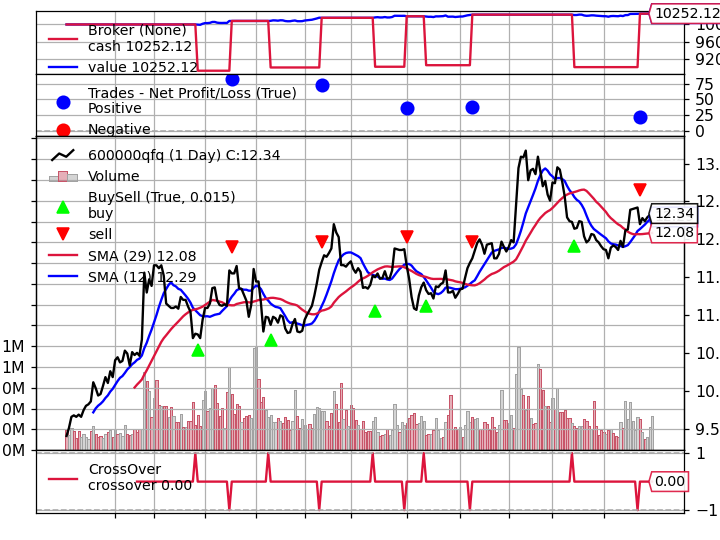

[[<Figure size 640x480 with 5 Axes>]]

In [4]:
# example of optimizing SMA crossover strategy parameters using 
# Particle Swarm Optimization in the opptunity python library
# https://github.com/claesenm/optunity

from datetime import datetime
import backtrader as bt

import optunity
import optunity.metrics
import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])



class SmaCross(bt.Strategy): # 这是信号策略
    params = (
        ('sma1', 10), # 需要优化的参数1，短期均线窗口
        ('sma2', 30), # 需要优化的参数2，长期均线窗口
    )
    def __init__(self):
        SMA1 = bt.ind.SMA(period=int(self.params.sma1)) # 用int取整
        SMA2 = bt.ind.SMA(period=int(self.params.sma2)) # 用int取整
        self.crossover = bt.ind.CrossOver(SMA1, SMA2)


    
    def next(self):
        if not self.position:           
            if self.crossover > 0:              
                self.buy(size=100)
       
        elif self.crossover < 0:            
            self.sell(size=100)





################
# 主程序入口
##############

# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000qfq.csv')
datapath = '600000qfq.csv'
# 创建行情数据对象，加载数据
data0 = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2019, 1, 1),  # 起始日
    todate=datetime(2019, 12, 31))  # 结束日


# 评估函数，输入参数，返回评估函数值，这里是总市值，要求最大化
def runstrat(sma1,sma2):
    
    print('I am called',datetime.now().strftime('%H:%M:%S'))
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross, sma1=sma1, sma2=sma2)

    cerebro.adddata(data0)
    cerebro.broker.setcash(10000.0)  # 设置初始资金
    cerebro.run()
    return cerebro.broker.getvalue()


#  执行优化，第一个参数是评估函数
# 执行5次回测（num_evals,实战时回测次数要设大一些，比如100次），设置两个参数sma1,sma2的取值范围
# solver_name可取算法包括 particle swarm,sobol,random search,cma-es,grid search
opt = optunity.maximize(runstrat,  num_evals=10,solver_name='particle swarm', sma1=[2, 55], sma2=[2, 55])



########################################
# 优化完成，得到最优参数结果
optimal_pars, details, _ = opt
print('Optimal Parameters:')
print('sma1 = %.2f' % optimal_pars['sma1'])
print('sma2 = %.2f' % optimal_pars['sma2'])
# 利用最优参数最后回测一次，作图
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross, sma1=optimal_pars['sma1'], sma2=optimal_pars['sma2'])
cerebro.adddata(data0)
cerebro.run()
cerebro.plot()

  0%|                                                                                                     | 0/5 [00:00<?, ?it/s]

I am called 23:17:25
I am called 23:17:25
I am called 23:17:25
I am called 23:17:25


I am called 23:17:26

Results: 'runstrat'  
   Best score: 9905.33  
   Best parameter:
      'sma1' : 19  
      'sma2' : 36  
 
   Random seed: 436751568  
 
   Evaluation time   : 0.22267460823059082 sec    [98.95 %]
   Optimization time : 0.0023598670959472656 sec    [1.05 %]
   Iteration time    : 0.22503447532653809 sec    [22.22 iter/sec]
 
best_param_fast:  19
best_param_slow:  36
best_score:  9905.33
5
终值 9905.33


<IPython.core.display.Javascript object>


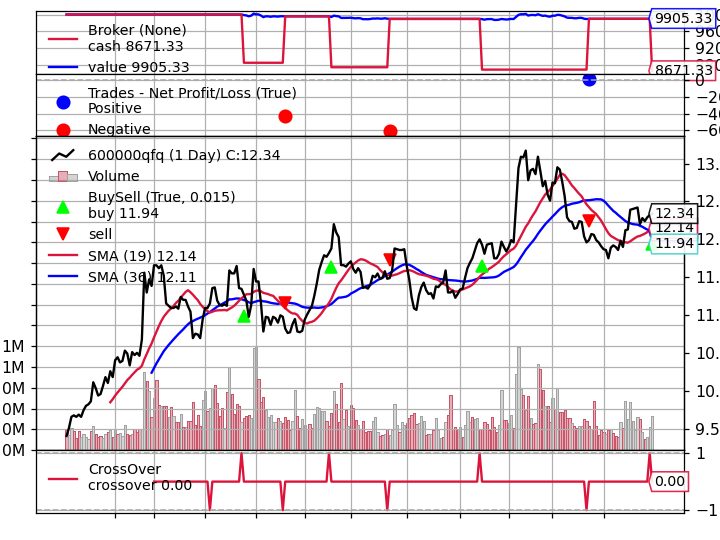

[[<Figure size 640x480 with 5 Axes>]]

In [7]:
# https://github.com/SimonBlanke/Gradient-Free-Optimizers

from datetime import datetime
import backtrader as bt

import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])

import numpy as np
import gradient_free_optimizers as gfo

class SmaCross(bt.Strategy): # 这是信号策略
    params = (
        ('sma1', 10), # 需要优化的参数1，短期均线窗口
        ('sma2', 30), # 需要优化的参数2，长期均线窗口
    )
    def __init__(self):
        SMA1 = bt.ind.SMA(period=self.params.sma1) # 用int取整
        SMA2 = bt.ind.SMA(period=self.params.sma2) # 用int取整
        self.crossover = bt.ind.CrossOver(SMA1, SMA2)


    
    def next(self):
        if not self.position:           
            if self.crossover > 0:              
                self.buy(size=100)
       
        elif self.crossover < 0:            
            self.sell(size=100)





################
# 主程序入口
##############
# 评估函数，输入参数，返回评估函数值，这里是总市值，要求最大化
def runstrat(para):
    print('I am called',datetime.now().strftime('%H:%M:%S'))

    if para['sma1'] >= para['sma2']: 
        # 若短期均线窗口sma1大于等于长期均线窗口sma2，则拒绝
        return np.nan 

    
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SmaCross, sma1=para['sma1'], sma2=para['sma2'])

    cerebro.adddata(data0)
    cerebro.broker.setcash(10000.0)  # 设置初始资金
    cerebro.run()
    score = cerebro.broker.getvalue()
    return score


# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000qfq.csv')
datapath = '600000qfq.csv'
# 创建行情数据对象，加载数据
data0 = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列.(openinterest是期货交易使用的)
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2019, 1, 1),  # 起始日
    todate=datetime(2019, 12, 31))  # 结束日


# 参数搜索空间
search_space = {
"sma1": np.arange(2, 55, 1), # 快速均线窗口，步长可为整数，也可为小数
"sma2": np.arange(2, 55, 1), # # 慢速均线窗口
}

iterations = 5 # 搜索迭代次数

# 可以使用的优化器
#  ['HillClimbingOptimizer',
# 'RepulsingHillClimbingOptimizer',
# 'SimulatedAnnealingOptimizer',
# 'RandomSearchOptimizer',
# 'RandomRestartHillClimbingOptimizer',
# 'RandomAnnealingOptimizer',
# 'ParallelTemperingOptimizer',
# 'ParticleSwarmOptimizer',
# 'EvolutionStrategyOptimizer',
# 'DecisionTreeOptimizer']

# 创建优化器
opt = gfo.EvolutionStrategyOptimizer(search_space)
# 执行搜索，参数是目标函数和迭代次数，其它参数请参考函数源码
opt.search(runstrat, n_iter=iterations) 

########################################
# 优化完成，得到最优参数结果
best_param_fast = opt.best_para['sma1']
best_param_slow = opt.best_para['sma2']

print('best_param_fast: ',best_param_fast)
print('best_param_slow: ', best_param_slow)

print('best_score: ', opt.best_score)
print(opt.n_iter)

###################################################

# 利用最优参数最后回测一次，作图
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross, sma1=best_param_fast, sma2=best_param_slow)
cerebro.adddata(data0)
cerebro.run()
print('终值', cerebro.broker.getvalue())
cerebro.plot()

初始市值: 10000.00
2000-01-14, in next, isover 0.00
2000-01-17, in next, isover 0.00
2000-01-18, in next, isover 0.00
2000-01-19, in next, isover 0.00
2000-01-20, in next, isover 0.00
2000-01-21, in next, isover 1.00
2000-01-24, in next, isover 0.00
2000-01-25, in next, isover 1.00
2000-01-25, 创建买单
2000-01-26, 买单执行, 1.95
2000-01-26, in next, isover 1.00
2000-01-27, in next, isover 1.00
2000-01-28, in next, isover 0.00
2000-02-14, in next, isover 1.00
2000-02-15, in next, isover 1.00
2000-02-16, in next, isover 1.00
2000-02-16, 创建卖单
2000-02-17, 卖单执行, 1.94
毛收益 -1.46, 扣佣后收益 -1.85, 佣金 0.39
2000-02-17, in next, isover 1.00
2000-02-18, in next, isover 1.00
2000-02-21, in next, isover 1.00
2000-02-21, 创建买单
2000-02-22, 买单执行, 2.05
2000-02-22, in next, isover 1.00
2000-02-22, 创建卖单
2000-02-23, 卖单执行, 1.93
毛收益 -11.80, 扣佣后收益 -12.20, 佣金 0.40
2000-02-23, in next, isover 1.00
2000-02-24, in next, isover 1.00
2000-02-25, in next, isover 1.00
2000-02-28, in next, isover 1.00
2000-02-28, 创建买单
2000-02-29, 买单执行

<IPython.core.display.Javascript object>


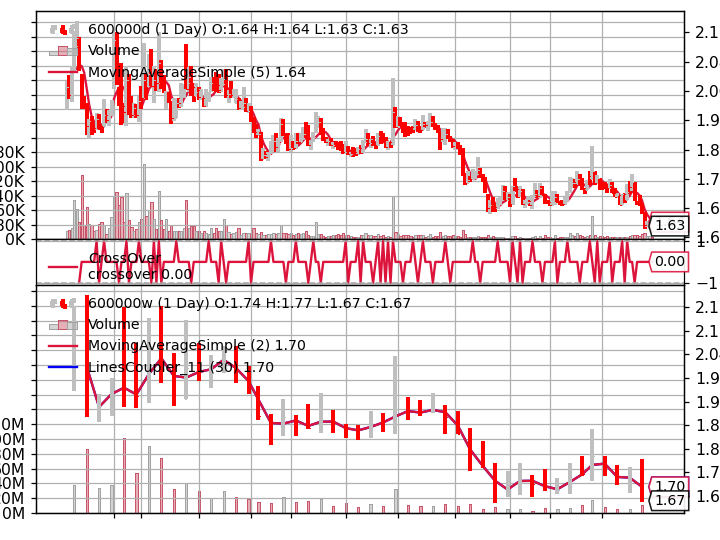

[[<Figure size 640x480 with 5 Axes>]]

In [20]:
from datetime import datetime
import backtrader as bt
import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])


# 创建策略类
class SmaCross(bt.Strategy):

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行, %.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单 Canceled/Margin/Rejected')

    

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                  (trade.pnl, trade.pnlcomm, trade.commission))

    def __init__(self):
        # 5日移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(self.data, period=5)
        # 2周线移动平均线
        self.move_average2 = bt.ind.MovingAverageSimple(
            self.datas[1].close, period=2)

        # 日线交叉信号指标
        self.crossover = bt.ind.CrossOver(self.data, self.move_average)

        # 日移动均线和周移动均线的差
        self.isover = self.move_average > self.move_average2()

    def next(self):
      
        self.log('in next, isover %0.2f' % self.isover[0])
        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.crossover > 0 and self.isover==1:
                self.log('创建买单')
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.crossover < 0 and not self.isover==0:
            self.log('创建卖单')
#             self.close()
            self.sell(size=100)


##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()

# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000d.csv')  # 日线数据
# datapath2 = os.path.join(modpath, './600000w.csv')  #周线数据
datapath = '600000d.csv'  # 日线数据
datapath2 = '600000w.csv' #周线数据
# 日线行情数据对象，加载数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2000, 1, 4),  # 起始日
    todate=datetime(2000, 12, 29))  # 结束日

# 周线行情数据对象，加载数据
data2 = bt.feeds.GenericCSVData(
    dataname=datapath2,
    datetime=2,  # 日期行所在列
    open=4,  # 开盘价所在列
    high=5,  # 最高价所在列
    low=6,  # 最低价所在列
    close=3,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2000, 1, 4),  # 起始日
    todate=datetime(2000, 12, 29))  # 结束日

cerebro.adddata(data)  # 将行情数据对象注入引擎
cerebro.adddata(data2)  # 将行情数据对象注入引擎
cerebro.addstrategy(SmaCross)  # 将策略注入引擎

cerebro.broker.setcash(10000.0)  # 设置初始资金
cerebro.broker.setcommission(0.001)  # 佣金费率
# 固定滑点，也可用cerebro.broker.set_slippage_perc()设置百分比滑点
cerebro.broker.set_slippage_fixed(0.05)

print('初始市值: %.2f' % cerebro.broker.getvalue())

cerebro.run(stdstats=False, runonce=False)
print('最终市值: %.2f' % cerebro.broker.getvalue())
cerebro.plot(style='bar')

初始市值: 10000.00
2000-01-25, 创建买单
2000-01-26, 买单执行, 1.95
2000-04-17, 创建卖单
2000-04-18, 卖单执行, 1.97
毛收益 1.65, 扣佣后收益  1.26, 佣金 0.39
2000-06-13, 创建买单
2000-06-14, 买单执行, 1.94
2000-07-03, 创建卖单
2000-07-04, 卖单执行, 1.82
毛收益 -11.92, 扣佣后收益 -12.30, 佣金 0.38
2000-07-19, 创建买单
2000-07-20, 买单执行, 1.89
2000-07-24, 创建卖单
2000-07-25, 卖单执行, 1.84
毛收益 -5.38, 扣佣后收益 -5.75, 佣金 0.37
2000-07-27, 创建买单
2000-07-28, 买单执行, 1.96
2000-08-10, 创建卖单
2000-08-11, 卖单执行, 1.89
毛收益 -7.13, 扣佣后收益 -7.51, 佣金 0.38
2000-08-14, 创建买单
2000-08-15, 买单执行, 1.92
2000-08-29, 创建卖单
2000-08-30, 卖单执行, 1.85
毛收益 -6.97, 扣佣后收益 -7.35, 佣金 0.38
2000-10-10, 创建买单
2000-10-11, 买单执行, 1.76
2000-11-03, 创建卖单
2000-11-06, 卖单执行, 1.69
毛收益 -7.36, 扣佣后收益 -7.71, 佣金 0.35
2000-11-09, 创建买单
2000-11-10, 买单执行, 1.76
2000-11-27, 创建卖单
2000-11-28, 卖单执行, 1.75
毛收益 -1.98, 扣佣后收益 -2.33, 佣金 0.35
最终市值: 9958.31


<IPython.core.display.Javascript object>


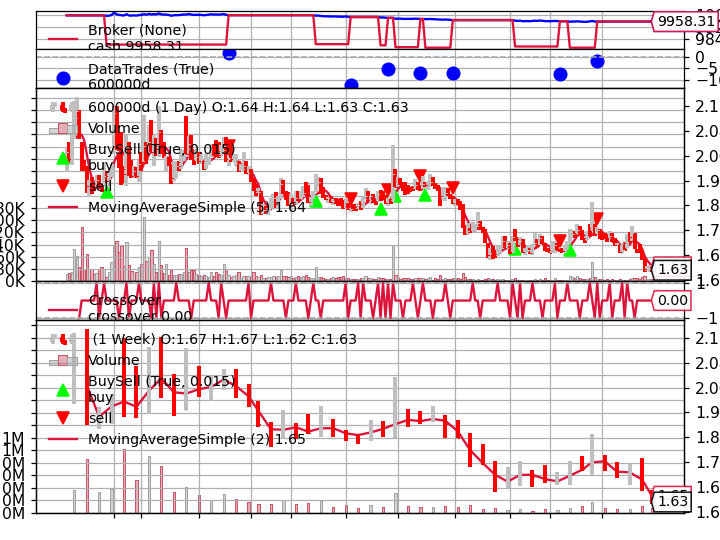

[[<Figure size 640x480 with 7 Axes>]]

In [21]:
from datetime import datetime
import backtrader as bt
import os.path  # 管理路径
import sys  # 发现脚本名字(in argv[0])


# 创建策略类
class SmaCross(bt.Strategy):

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行, %.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单 Canceled/Margin/Rejected')

        # 重置订单
        self.order = None

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                  (trade.pnl, trade.pnlcomm, trade.commission))

    def __init__(self):
        # 5日移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(self.data, period=5)
        # 2周线移动平均线
        self.move_average2 = bt.ind.MovingAverageSimple(
            self.datas[1].close, period=2)

        # 日线交叉信号指标
        self.crossover = bt.ind.CrossOver(self.data, self.move_average)

    def next(self):

        # print(self.data1.datetime.datetime(0),len(self.data1), self.data1.open[0],self.data1.high[0],self.data1.low[0],self.data1.close[0],)
        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.crossover > 0 and self.move_average[0] > self.move_average2[0]:
                self.log('创建买单')
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.crossover < 0 and self.move_average[0] < self.move_average2[0]:
            self.log('创建卖单')
            self.close()


##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()

# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000d.csv')  # 日线数据
datapath =  '600000d.csv'  # 日线数据

# 日线行情数据对象，加载数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列
    dtformat=('%Y%m%d'),  # 日期格式
    timeframe=bt.TimeFrame.Days, # 日线数据
    fromdate=datetime(2000, 1, 4),  # 起始日
    todate=datetime(2000, 12, 29))  # 结束日

cerebro.adddata(data)  # 将行情数据对象注入引擎

tframes = dict(
    daily=bt.TimeFrame.Days,
    weekly=bt.TimeFrame.Weeks,
    monthly=bt.TimeFrame.Months)

cerebro.resampledata(data, timeframe=tframes['weekly'], compression=1)
cerebro.addstrategy(SmaCross)  # 将策略注入引擎

cerebro.broker.setcash(10000.0)  # 设置初始资金
cerebro.broker.setcommission(0.001)  # 佣金费率
# 固定滑点，也可用cerebro.broker.set_slippage_perc()设置百分比滑点
cerebro.broker.set_slippage_fixed(0.05)

print('初始市值: %.2f' % cerebro.broker.getvalue())

cerebro.run()
print('最终市值: %.2f' % cerebro.broker.getvalue())
cerebro.plot(style='bar')


2006-01-02 09:10:00 1 3578.73 3588.4 3578.73 3588.03
2006-01-02 09:20:00 2 3588.09 3591.83 3587.75 3590.62
2006-01-02 09:30:00 3 3590.64 3591.86 3590.02 3590.65
2006-01-02 09:40:00 4 3591.4 3602.86 3591.34 3602.43
2006-01-02 09:50:00 5 3602.96 3605.49 3602.57 3602.7
2006-01-02 10:00:00 6 3602.61 3602.61 3599.29 3600.4
2006-01-02 10:10:00 7 3600.28 3603.31 3600.28 3601.05
2006-01-02 10:20:00 8 3600.82 3600.82 3598.58 3599.74
2006-01-02 10:30:00 9 3599.96 3601.57 3599.87 3601.11
2006-01-02 10:40:00 10 3601.48 3603.04 3601.07 3602.69
2006-01-02 10:50:00 11 3602.61 3602.86 3601.42 3601.89
2006-01-02 11:00:00 12 3601.99 3602.54 3600.46 3601.22
2006-01-02 11:10:00 13 3601.26 3601.58 3599.07 3599.85
2006-01-02 11:20:00 14 3599.72 3599.85 3590.6 3590.63
2006-01-02 11:30:00 15 3590.66 3593.72 3590.32 3593.72
2006-01-02 11:40:00 16 3593.78 3595.8 3593.78 3595.26
2006-01-02 11:50:00 17 3595.43 3597.04 3594.81 3597.04
2006-01-02 12:00:00 18 3596.77 3599.48 3596.55 3598.4
2006-01-02 12:10:00 19 359

<IPython.core.display.Javascript object>


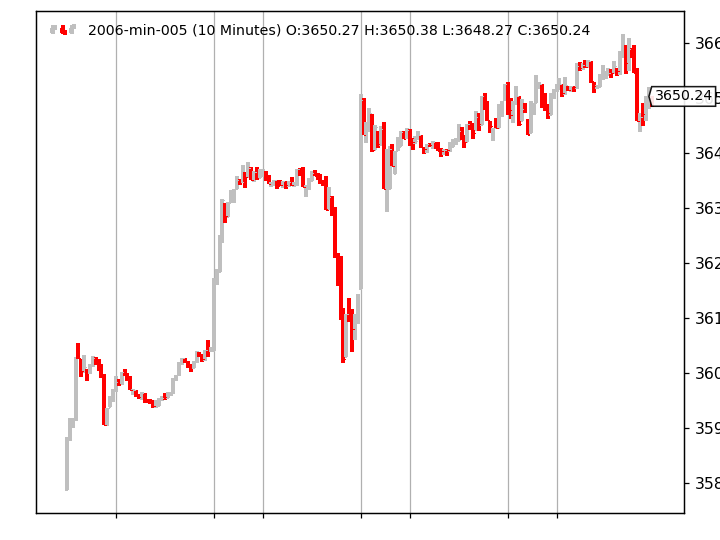

[[<Figure size 640x480 with 2 Axes>]]

In [23]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import backtrader as bt
import backtrader.feeds as btfeeds
from datetime import datetime,time

from requests import session


class testStrategy(bt.Strategy):
    def next(self):
        print(self.data0.datetime.datetime(0), len(self.data0),
              self.data0.open[0], self.data0.high[0], self.data0.low[0], self.data0.close[0],)


# Create a cerebro entity
cerebro = bt.Cerebro(stdstats=False)

# Add a strategy
cerebro.addstrategy(testStrategy)

# Load the Data
datapath = './2006-min-005.csv'
data = btfeeds.BacktraderCSVData(
    dataname=datapath, timeframe=bt.TimeFrame.Minutes,
    todate=datetime(2006, 1, 6),   

    
)


cerebro.resampledata(
    data,
    timeframe=bt.TimeFrame.Minutes,
    compression=10,

    )


cerebro.run()
cerebro.plot()

2015-09-23 20:57:00 3069.1 3067.0 3067.0 3067.0
2015-09-23 20:58:00 3067.0 3066.0 3066.0 3066.1
2015-09-23 20:59:00 3066.2 3069.0 3065.0 3067.0
2015-09-23 21:00:00 3068.07 3069.0 3067.0 3068.0
2015-09-23 21:01:00 3069.0 3069.0 3069.0 3069.0


<IPython.core.display.Javascript object>


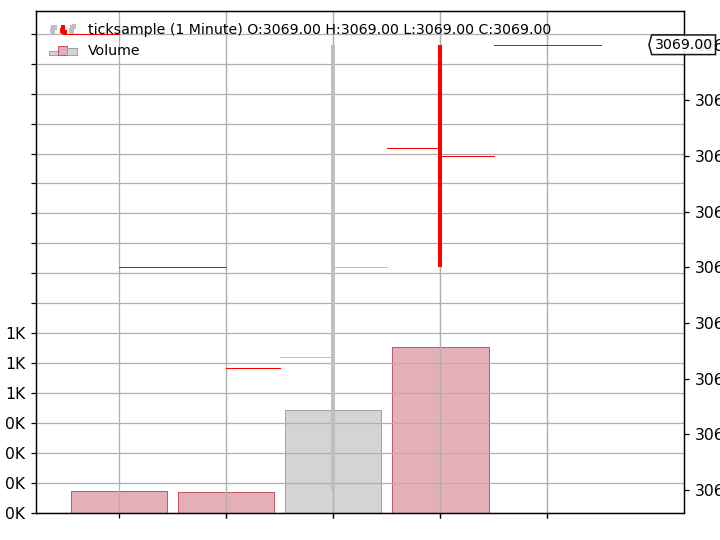

[[<Figure size 640x480 with 2 Axes>]]

In [28]:
import backtrader as bt
import backtrader.feeds as btfeeds
import datetime

class testStrategy(bt.Strategy):
    def next(self):
        print(self.data0.datetime.datetime(0),self.data0.open[0],self.data0.high[0],self.data0.low[0],self.data0.close[0],)

# Create a cerebro entity
cerebro = bt.Cerebro(stdstats=False)

# Add a strategy
cerebro.addstrategy(testStrategy)

# Load the Data
datapath =  './ticksample.csv'

data = btfeeds.GenericCSVData(
    dataname=datapath,
    dtformat='%Y-%m-%dT%H:%M:%S.%f',
    timeframe=bt.TimeFrame.Ticks,
    # sessionstart = datetime.time(9,30,00),  
    # sessionend = datetime.time(15,00,00), 
)

# Handy dictionary for the argument timeframe conversion
tframes = dict(
    ticks=bt.TimeFrame.Ticks,
    microseconds=bt.TimeFrame.MicroSeconds,
    seconds=bt.TimeFrame.Seconds,
    minutes=bt.TimeFrame.Minutes,
    daily=bt.TimeFrame.Days,
    weekly=bt.TimeFrame.Weeks,
    monthly=bt.TimeFrame.Months)

# Resample the data    
cerebro.resampledata(
    data,
    timeframe=tframes['minutes'],
    compression=1,
    # bar2edge=True,
    # adjbartime=True,
    # rightedge=False,
    # boundoff=1 
    )



# Run over everything
cerebro.run()

# Plot the result
cerebro.plot(style='bar')


Profit ... or Loss: 1300.80


<IPython.core.display.Javascript object>


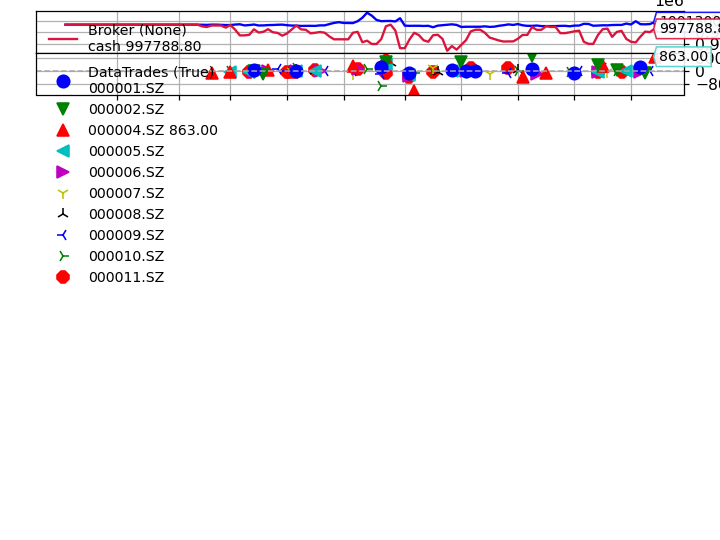

[[<Figure size 640x480 with 2 Axes>]]

In [34]:
import datetime
import glob
import os.path

import backtrader as bt



# 创建策略类
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(
        fast_period=2,  # 快速移动平均期数
        slow_period = 5,)  # 慢速移动平均期数

    def __init__(self):
        # 股票stock的快速移动平均线指标
        fastMA = {stock: bt.ind.MovingAverageSimple(stock, period=self.params.fast_period, plot=False) for stock in self.datas}

        # 股票stock的慢速移动平均线指标
        slowMA = {stock: bt.ind.MovingAverageSimple(stock, period=self.params.slow_period, plot=False) for stock in self.datas}

        # 股票stock的移动均线交叉信号指标
        self.crossover = {stock: bt.ind.CrossOver(fastMA[stock], slowMA[stock], plot=True) for stock in self.datas}        

        self.orderlist = []    # 以往订单列表


    def next(self): # 每个新bar触发调用一次，相当于其他框架的 on_bar()方法
        for o in self.orderlist:
            self.cancel(o) # 取消以往所有订单
            self.orderlist=[] # 置空

        for stock in self.datas:
            if not self.getposition(stock):  # 还没有仓位，才可以买
                if self.crossover[stock] > 0:  # 金叉 
                    order = self.buy(data=stock,size=100)
                    self.orderlist.append(order)

            # 已有仓位，才可以卖
            elif self.crossover[stock] < 0:  # 死叉          
                order = self.close(data=stock, size=100)
                self.orderlist.append(order)


##########################
# 主程序开始
#########################

cerebro = bt.Cerebro()

datadir = './data'  # 数据文件位于本脚本所在目录的data子目录中
datafilelist = glob.glob(os.path.join(datadir, '*'))  # 数据文件路径列表
maxstocknum = 10  # 股票池最大股票数目
datafilelist = datafilelist[0:maxstocknum]  # 截取指定数量的股票池

# 将目录datadir中的所有数据文件加载进系统
for fname in datafilelist:
    data = bt.feeds.GenericCSVData(
        dataname=fname,
        datetime=2,  # 日期行所在列
        open=4,  # 开盘价所在列
        high=5,  # 最高价所在列
        low=6,  # 最低价所在列
        close=3,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        openinterest=-1,  # 无未平仓量列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime.datetime(2010, 1, 1),  # 起始日
        todate=datetime.datetime(2020, 7, 10),  # 结束日
        timeframe=bt.TimeFrame.Months,  # 月线数据
        plot=False
    )
    cerebro.adddata(data)

# 注入策略
cerebro.addstrategy(SmaCross)

# 设置现金
startcash = 1000000
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=0.001)

cerebro.run()

# 最终收益或亏损
pnl = cerebro.broker.get_value() - startcash
print('Profit ... or Loss: {:.2f}'.format(pnl))
cerebro.plot(style='bar')

In [35]:
import datetime
import glob
import os.path

import backtrader as bt


class St(bt.Strategy):
    params = dict(
        selcperc=0.10,  # 股票池中挑选标的股票的比例
        rperiod=1,  # 收益率计算期数, 默认1期，即月度收益率
        vperiod=36,  # 波动率计算回看期数
        mperiod=12,  # 动量指标计算回看期数
        reserve=0.05  # 5% 预留资本
    )

    def log(self, arg):
        print('{} {}'.format(self.datetime.date(), arg))

    def __init__(self):
        # 计算要挑出的标的股票数量
        self.selnum = int(len(self.datas) * self.p.selcperc)

        # 为每支选中股票分配资金比率，预留部分资金以防止买股资金不足。
        # 计算购买数量都是以本期收盘价计算，而订单实际是以下期开盘价执行。
        # 因为开盘价可能上升，由此可能产生资金缺口
        self.perctarget = (1.0 - self.p.reserve) / self.selnum

        # 收益率指标计算
        rs = [bt.ind.PctChange(d, period=self.p.rperiod) for d in self.datas]
        # 波动率指标计算
        vs = [bt.ind.StdDev(ret, period=self.p.vperiod) for ret in rs]
        # 动量指标计算
        ms = [bt.ind.ROC(d, period=self.p.mperiod) for d in self.datas]

        # 数据:指标线字典，在next方法中，将按指标进行排序。
        # 对每个数据（股票），对应的评价指标为 ms/vs,它是线对象
        self.ranks = {d: m / v for d, v, m in zip(self.datas, vs, ms)}

    def next(self):       
        # 对数据：指标字典按指标当前值排序,结果ranks是list
        ranks = sorted(
            self.ranks.items(),  # 获得(d, 指标线)对
            key=lambda x: x[1][0],  # 按指标线(元素1) 的当前值（索引0） 排序
            reverse=True,  # 从大到小排序
        )

        # 把排序前selnum位的股票挑出来放进字典rtop，即选中排序表
        rtop = dict(ranks[:self.selnum])

        # 剩余的股票放进字典rbot
        rbot = dict(ranks[self.selnum:])

        # 当前持有仓位的股票列表
        posdata = [d for d, pos in self.getpositions().items() if pos]

        # 对未选中的（不在选中排序表中），但目前有仓位的股票，清仓
        # 先清仓以释放现金
        for d in (d for d in posdata if d not in rtop):
            self.log('Leave {} - Rank {:.2f}'.format(d._name, rbot[d][0]))
            self.order_target_percent(d, target=0.0)  # 清仓

        # 对当前有仓位，并且在选中排序表中的股票，进行仓位数量调整
        for d in (d for d in posdata if d in rtop):
            self.log('Rebal {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)  # 调整仓位数量
            del rtop[d]  # 排序表中，删除该股, 以简化下次迭代

        # 对剩余的新进排序表的股票（当前无仓位），买入
        # 本操作要最后做
        for d in rtop:
            self.log('Enter {} - Rank {:.2f}'.format(d._name, rtop[d][0]))
            self.order_target_percent(d, target=self.perctarget)


##########################
# 主程序开始
#########################

cerebro = bt.Cerebro()

datadir = './data'  # 数据文件位于本脚本所在目录的data子目录中
datafilelist = glob.glob(os.path.join(datadir, '*'))  # 数据文件路径列表
maxstocknum = 200  # 股票池最大股票数目
datafilelist = datafilelist[0:maxstocknum]  # 截取指定数量的股票池

# 将目录datadir中的所有数据文件加载进系统
for fname in datafilelist:
    data = bt.feeds.GenericCSVData(
        dataname=fname,
        datetime=2,  # 日期行所在列
        open=4,  # 开盘价所在列
        high=5,  # 最高价所在列
        low=6,  # 最低价所在列
        close=3,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        openinterest=-1,  # 无未平仓量列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime.datetime(2010, 1, 1),  # 起始日
        todate=datetime.datetime(2020, 7, 10),  # 结束日
        timeframe=bt.TimeFrame.Months  # 月线数据
    )
    cerebro.adddata(data)

# 注入策略
cerebro.addstrategy(St)

# 设置现金
startcash = 1000000
cerebro.broker.setcash(startcash)

cerebro.run()

# 最终收益或亏损
pnl = cerebro.broker.get_value() - startcash
print('Profit ... or Loss: {:.2f}'.format(pnl))


2018-01-31 Enter 000333.SZ - Rank 11.21
2018-01-31 Enter 000063.SZ - Rank 8.80
2018-01-31 Enter 000568.SZ - Rank 8.68
2018-01-31 Enter 000338.SZ - Rank 6.66
2018-01-31 Enter 000001.SZ - Rank 6.27
2018-01-31 Enter 000002.SZ - Rank 5.54
2018-01-31 Enter 000537.SZ - Rank 5.48
2018-01-31 Enter 000513.SZ - Rank 4.76
2018-01-31 Enter 000538.SZ - Rank 4.65
2018-01-31 Enter 000069.SZ - Rank 4.58
2018-01-31 Enter 000507.SZ - Rank 4.54
2018-01-31 Enter 000488.SZ - Rank 4.50
2018-01-31 Enter 000596.SZ - Rank 4.47
2018-01-31 Enter 000504.SZ - Rank 3.77
2018-01-31 Enter 000425.SZ - Rank 3.41
2018-01-31 Enter 000039.SZ - Rank 3.14
2018-01-31 Enter 000301.SZ - Rank 2.83
2018-01-31 Enter 000036.SZ - Rank 2.68
2018-01-31 Enter 000016.SZ - Rank 2.58
2018-01-31 Enter 000423.SZ - Rank 2.56
2018-02-28 Leave 000425.SZ - Rank 0.42
2018-02-28 Leave 000039.SZ - Rank 0.94
2018-02-28 Leave 000036.SZ - Rank 0.87
2018-02-28 Leave 000423.SZ - Rank 0.84
2018-02-28 Rebal 000333.SZ - Rank 8.03
2018-02-28 Rebal 000063.

2019-02-28 Leave 000528.SZ - Rank 0.05
2019-02-28 Leave 000409.SZ - Rank -1.00
2019-02-28 Leave 000401.SZ - Rank 0.81
2019-02-28 Leave 000032.SZ - Rank 0.85
2019-02-28 Leave 000555.SZ - Rank 0.77
2019-02-28 Leave 000600.SZ - Rank -0.01
2019-02-28 Leave 000547.SZ - Rank -0.08
2019-02-28 Rebal 000338.SZ - Rank 2.94
2019-02-28 Rebal 000596.SZ - Rank 2.29
2019-02-28 Rebal 000429.SZ - Rank 3.04
2019-02-28 Rebal 000597.SZ - Rank 2.97
2019-02-28 Rebal 000629.SZ - Rank 2.31
2019-02-28 Rebal 000516.SZ - Rank 1.43
2019-02-28 Rebal 000628.SZ - Rank 4.99
2019-02-28 Rebal 000622.SZ - Rank 3.64
2019-02-28 Rebal 000543.SZ - Rank 2.65
2019-02-28 Rebal 000151.SZ - Rank 1.48
2019-02-28 Rebal 000550.SZ - Rank 1.39
2019-02-28 Rebal 000070.SZ - Rank 5.22
2019-02-28 Enter 000037.SZ - Rank 2.68
2019-02-28 Enter 000068.SZ - Rank 2.40
2019-02-28 Enter 000058.SZ - Rank 2.15
2019-02-28 Enter 000089.SZ - Rank 1.77
2019-02-28 Enter 000027.SZ - Rank 1.76
2019-02-28 Enter 000422.SZ - Rank 1.76
2019-02-28 Enter 00016

2020-02-28 Leave 000037.SZ - Rank 0.74
2020-02-28 Leave 000601.SZ - Rank 3.33
2020-02-28 Leave 000049.SZ - Rank 3.14
2020-02-28 Leave 000518.SZ - Rank 1.28
2020-02-28 Leave 000007.SZ - Rank 1.64
2020-02-28 Rebal 000063.SZ - Rank 4.11
2020-02-28 Rebal 000568.SZ - Rank 4.25
2020-02-28 Rebal 000338.SZ - Rank 6.80
2020-02-28 Rebal 000513.SZ - Rank 4.52
2020-02-28 Rebal 000596.SZ - Rank 4.08
2020-02-28 Rebal 000425.SZ - Rank 4.14
2020-02-28 Rebal 000100.SZ - Rank 9.00
2020-02-28 Rebal 000021.SZ - Rank 11.12
2020-02-28 Rebal 000032.SZ - Rank 9.68
2020-02-28 Rebal 000157.SZ - Rank 9.56
2020-02-28 Rebal 000066.SZ - Rank 7.04
2020-02-28 Rebal 000523.SZ - Rank 3.88
2020-02-28 Rebal 000009.SZ - Rank 5.86
2020-02-28 Rebal 000034.SZ - Rank 7.16
2020-02-28 Rebal 000078.SZ - Rank 4.11
2020-02-28 Enter 000016.SZ - Rank 7.38
2020-02-28 Enter 000004.SZ - Rank 6.42
2020-02-28 Enter 000158.SZ - Rank 6.30
2020-02-28 Enter 000526.SZ - Rank 5.68
2020-02-28 Enter 000030.SZ - Rank 3.99
2020-03-31 Leave 000568.

---------------------------- TRADE ---------------------------------
1: Data Name:                            600000qfq
2: Bar Num:                              45
3: Current date:                         2019-03-13
4: Status:                               Trade Complete
5: Ref:                                  1131
6: PnL:                                  -13.3
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            600000qfq
2: Bar Num:                              58
3: Current date:                         2019-04-01
4: Status:                               Trade Complete
5: Ref:                                  1132
6: PnL:                                  7.26
--------------------------------------------------------------------
---------------------------- TRADE ---------------------------------
1: Data Name:                            600000qfq
2: Bar Num:  

<IPython.core.display.Javascript object>


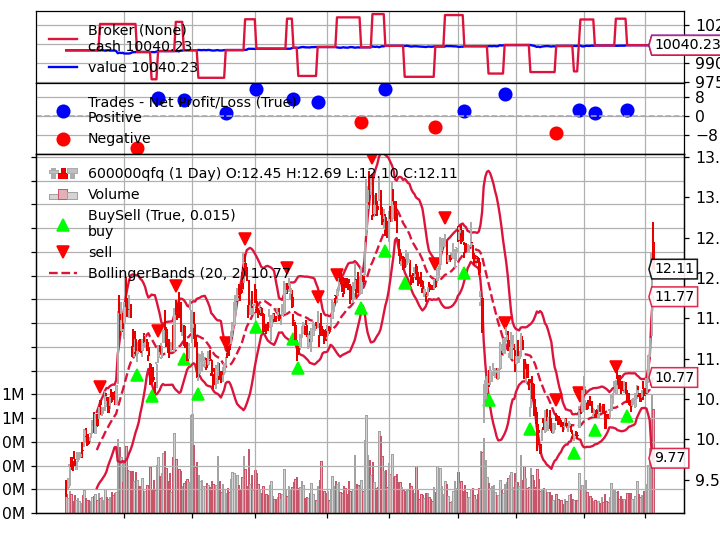

[[<Figure size 640x480 with 4 Axes>]]

In [36]:
import backtrader as bt
from datetime import datetime
import os.path  # 管理路径
import sys  # 发现脚本名字


class BOLLStrat(bt.Strategy):
    '''
    布林线均值回归策略
 
    进入标准:
        - 长仓:
            - 收盘价低于下轨
            - 创建Stop买单， 当价格向上突破下轨时，买入
        - 短仓（允许做空）: 
            - 收盘价高于上轨
            - 创建Stop卖单， 当价格向下突破上轨时，卖出
    退出标准
        - 长/短: 价格触及中线
    '''

    params = (
        ("period", 20),  # 布林线周期
        ("devfactor", 2),  # 偏离因子
        ("size", 20),  # 订单数量
        ("debug", False)  # 是否调试
    )

    def __init__(self):
        self.boll = bt.indicators.BollingerBands(
            period=self.p.period, devfactor=self.p.devfactor)
        #self.sx = bt.indicators.CrossDown(self.data.close, self.boll.lines.top)
        #self.lx = bt.indicators.CrossUp(self.data.close, self.boll.lines.bot)

    def next(self):
        # 未决订单列表
        orders = self.broker.get_orders_open()

        # 取消所有未决订单
        if orders:
            for order in orders:
                self.broker.cancel(order)

        # 无仓位，准备建仓进入市场
        if not self.position:  # 没有仓位

            if self.data.close > self.boll.lines.top:  # 收盘价高于上轨

                self.sell(  # 卖出
                    exectype=bt.Order.Stop,
                    price=self.boll.lines.top[0],
                    size=self.p.size)

            if self.data.close < self.boll.lines.bot:  # 收盘价低于下轨
                self.buy(  # 买入
                    exectype=bt.Order.Stop,
                    price=self.boll.lines.bot[0],
                    size=self.p.size)

        # 有仓位，准备退出市场
        else:

            if self.position.size > 0:  # 有长仓
                self.sell(  # 限价卖单，以比中线更好的价格卖出平仓
                    exectype=bt.Order.Limit,
                    price=self.boll.lines.mid[0],
                    size=self.p.size)

            else:  # 有短仓，即持仓量为负值
                self.buy(  # 限价买单，以比中线更好的价格买入平仓
                    exectype=bt.Order.Limit,
                    price=self.boll.lines.mid[0],
                    size=self.p.size)

        if self.p.debug:
            print(
                '---------------------------- NEXT ----------------------------------'
            )
            print("1: Data Name:                            {}".format(
                data._name))
            print("2: Bar Num:                              {}".format(
                len(data)))
            print("3: Current date:                         {}".format(
                data.datetime.datetime()))
            print('4: Open:                                 {}'.format(
                data.open[0]))
            print('5: High:                                 {}'.format(
                data.high[0]))
            print('6: Low:                                  {}'.format(
                data.low[0]))
            print('7: Close:                                {}'.format(
                data.close[0]))
            print('8: Volume:                               {}'.format(
                data.volume[0]))
            print('9: Position Size:                       {}'.format(
                self.position.size))
            print(
                '--------------------------------------------------------------------'
            )

    def notify_trade(self, trade):
        if trade.isclosed:
            dt = self.data.datetime.date()

            print(
                '---------------------------- TRADE ---------------------------------'
            )
            print("1: Data Name:                            {}".format(
                trade.data._name))
            print("2: Bar Num:                              {}".format(
                len(trade.data)))
            print("3: Current date:                         {}".format(dt))
            print('4: Status:                               Trade Complete')
            print('5: Ref:                                  {}'.format(
                trade.ref))
            print('6: PnL:                                  {}'.format(
                round(trade.pnl, 2)))
            print(
                '--------------------------------------------------------------------'
            )


#Variable for our starting cash
startcash = 10000

# Create an instance of cerebro
cerebro = bt.Cerebro()

# Add our strategy
cerebro.addstrategy(BOLLStrat)

# 获取本脚本文件所在路径
modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
# 拼接得到数据文件全路径
# datapath = os.path.join(modpath, './600000qfq.csv')
datapath = '600000qfq.csv'
# 创建行情数据对象，加载数据
data = bt.feeds.GenericCSVData(
    dataname=datapath,
    datetime=2,  # 日期行所在列
    open=3,  # 开盘价所在列
    high=4,  # 最高价所在列
    low=5,  # 最低价所在列
    close=6,  # 收盘价价所在列
    volume=10,  # 成交量所在列
    openinterest=-1,  # 无未平仓量列
    dtformat=('%Y%m%d'),  # 日期格式
    fromdate=datetime(2019, 1, 1),  # 起始日
    todate=datetime(2020, 7, 8))  # 结束日

# Add the data to Cerebro
cerebro.adddata(data)

# Add a sizer
cerebro.addsizer(bt.sizers.FixedReverser, stake=10)

# Run over everything
cerebro.run()

#Get final portfolio Value
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#Print out the final result
print('Final Portfolio Value: ${}'.format(round(portvalue, 2)))
print('P/L: ${}'.format(round(pnl, 2)))

# Finally plot the end results
cerebro.plot(style='candlestick')

# jupyter只能跟踪主进程，没法跟踪子进程
将脚本另存为py文件，然后再运行

In [1]:
%%writefile  opt_multi.py
import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import matplotlib
from datetime import datetime

# 定义双均线策略
class MaCrossStrategy(bt.Strategy):
 
    params = (
        ('fast_length', 10),
        ('slow_length', 50)
    )
     
    def __init__(self):
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
         
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
 
    def next(self):
        if not self.position:
            if self.crossover > 0: 
                self.buy()
        elif self.crossover < 0: 
            self.close()

if __name__ == "__main__":
    
    cerebro = bt.Cerebro()

  
    # 从yahoo在线api取得股票AAPL的日线数据
#     data = bt.feeds.YahooFinanceData(dataname = 'AAPL', fromdate = datetime(2018, 1, 1), todate = datetime(2020, 1, 1))
    datapath = '600000qfq.csv'
    # 创建行情数据对象，加载数据
    data = bt.feeds.GenericCSVData(
        dataname=datapath,
        datetime=2,  # 日期行所在列
        open=3,  # 开盘价所在列
        high=4,  # 最高价所在列
        low=5,  # 最低价所在列
        close=6,  # 收盘价价所在列
        volume=10,  # 成交量所在列
        openinterest=-1,  # 无未平仓量列
        dtformat=('%Y%m%d'),  # 日期格式
        fromdate=datetime(2019, 1, 1),  # 起始日
        todate=datetime(2020, 7, 8))  # 结束日
    cerebro.adddata(data)

    #策略优化
    cerebro.optstrategy(
            MaCrossStrategy,
            fast_length = range(1, 11, 5), 
            slow_length = range(25, 35, 5))
    


    cerebro.broker.setcash(1000000.0)
    
    cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = "sharpe")
    cerebro.addanalyzer(btanalyzers.DrawDown, _name = "drawdown")
    cerebro.addanalyzer(btanalyzers.Returns, _name = "returns")
    
    # 运行优化，由于每个参数组合运行一次策略，所以back是返回的策略实例列表（每个实例对应一组参数值）
    back = cerebro.run()


    # 每个策略实例的结果以列表的形式保存在列表中。
    # 优化运行模式下，返回值是列表的列表,内列表只含一个元素，即策略实例
    par_list = [[x[0].params.fast_length, 
                x[0].params.slow_length,
                x[0].analyzers.returns.get_analysis()['rnorm100'], 
                x[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
                x[0].analyzers.sharpe.get_analysis()['sharperatio']
                ] for x in back]

    # 结果转成dataframe
    par_df = pd.DataFrame(par_list, columns = ['length_fast', 'length_slow', 'return', 'dd', 'sharpe'])

    print(par_df.head())

    par_df.to_csv('result.csv')


Writing opt_multi.py


In [2]:
%run opt_multi.py

   length_fast  length_slow    return        dd    sharpe
0            1           25  0.976133  1.138918 -0.887778
1            1           30  0.710859  1.188116 -0.615145
2            6           25  0.140335  1.744016 -1.366315
3            6           30  0.277163  1.902488 -1.153759


In [5]:
from xtquant import xtdata
print(dir(xtdata))

['CLIENT', 'MergeData', 'RPCClient', 'TimeListBuilder', '__all__', '__builtins__', '__cached__', '__curdir', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__rpc_config', '__rpc_init_status', '__spec__', '__xtdata_config', '_get_market_data_ex_221207', '_get_market_data_ex_ori_221207', 'abspath', 'add_sector', 'bson', 'create_array', 'data_dir', 'datetime_to_timetag', 'debug_mode', 'default_data_dir', 'dirname', 'download_cb_data', 'download_financial_data', 'download_financial_data2', 'download_history_contracts', 'download_history_data', 'download_history_data2', 'download_index_weight', 'download_sector_data', 'getDividFactors', 'get_cb_info', 'get_client', 'get_divid_factors', 'get_etf_info', 'get_financial_data', 'get_full_tick', 'get_holidays', 'get_index_weight', 'get_industry', 'get_instrument_detail', 'get_instrument_type', 'get_l2_order', 'get_l2_quote', 'get_l2_transaction', 'get_local_data', 'get_main_contract', 'get_market_data', 'get_market_data3', 'get_

In [19]:
from xtquant import xtdata
import pandas as pd
stock_code_list = ["002594.SZ"]
stock_code = "002594.SZ"
period = '1d'
start_time = '20230302'
end_time  = '20230502'
def on_progress(data):
    print(data)
xtdata.download_history_data2(stock_code_list, period, start_time=start_time, end_time=end_time, callback=on_progress)

# xtdata.download_history_data(stock_code, period=period, start_time=start_time, end_time=end_time)
dict_data = xtdata.get_market_data(field_list=[], stock_list=stock_code_list, period=period, start_time=start_time, end_time=end_time, count=-1, dividend_type='front', fill_data=True)
type(dict_data)
dict_data.keys()
dict_data.values()

{'finished': 1, 'total': 1, 'stockcode': '', 'message': '002594.SZ'}


dict_values([                20230302       20230303       20230306       20230307  \
002594.SZ  1677686400000  1677772800000  1678032000000  1678118400000   

                20230308       20230309       20230310       20230313  \
002594.SZ  1678204800000  1678291200000  1678377600000  1678636800000   

                20230314       20230315  ...       20230417       20230418  \
002594.SZ  1678723200000  1678809600000  ...  1681660800000  1681747200000   

                20230419       20230420       20230421       20230424  \
002594.SZ  1681833600000  1681920000000  1682006400000  1682265600000   

                20230425       20230426       20230427       20230428  
002594.SZ  1682352000000  1682438400000  1682524800000  1682611200000  

[1 rows x 41 columns],            20230302  20230303  20230306  20230307  20230308  20230309  \
002594.SZ    266.12    264.99     264.0    264.18     258.5     256.5   

           20230310  20230313  20230314  20230315  ...  20230417  20230418

In [72]:
from xtquant import xtdata
import pandas as pd
stock_code_list = ["002594.SZ"]
stock_code = "002594.SZ"
period = '5m'
start_time = '20230302'
end_time  = '20230502'
def on_progress(data):
    print(data)
xtdata.download_history_data2(stock_code_list, period, start_time=start_time, end_time=end_time, callback=on_progress)

# xtdata.download_history_data(stock_code, period=period, start_time=start_time, end_time=end_time)
start_time_get = '20230302093000'
end_time_get  = '20230421130000'
dict_data = xtdata.get_market_data(field_list=[], stock_list=stock_code_list, period=period, start_time=start_time_get, end_time=end_time_get, count=-1, dividend_type='front', fill_data=True)
type(dict_data)
dict_data.keys()
# dict_data.values()
type(dict_data['close'])
dict_data['close']

{'finished': 1, 'total': 1, 'stockcode': '', 'message': '002594.SZ'}


,20230302093500,20230302094000,20230302094500,20230302095000,20230302095500,20230302100000,20230302100500,20230302101000,20230302101500,20230302102000,...,20230421104500,20230421105000,20230421105500,20230421110000,20230421110500,20230421111000,20230421111500,20230421112000,20230421112500,20230421113000
002594.SZ,266.66,267.33,266.56,266.68,267.1,266.07,266.7,266.42,266.3,266.35,...,247.52,247.13,246.71,246.92,247.29,247.29,247.08,246.44,246.12,245.62


In [15]:
dict_data

{'time':                 20230303       20230306       20230307       20230308  \
 002594.SZ  1677772800000  1678032000000  1678118400000  1678204800000   
 
                 20230309       20230310       20230313       20230314  \
 002594.SZ  1678291200000  1678377600000  1678636800000  1678723200000   
 
                 20230315       20230316  ...       20230410       20230411  \
 002594.SZ  1678809600000  1678896000000  ...  1681056000000  1681142400000   
 
                 20230412       20230413       20230414       20230417  \
 002594.SZ  1681228800000  1681315200000  1681401600000  1681660800000   
 
                 20230418       20230419       20230420       20230421  
 002594.SZ  1681747200000  1681833600000  1681920000000  1682006400000  
 
 [1 rows x 35 columns],
 'open':            20230303  20230306  20230307  20230308  20230309  20230310  \
 002594.SZ    264.99     264.0    264.18     258.5     256.5     252.0   
 
            20230313  20230314  20230315  20230316  

In [10]:
type(dict_data['close'])

pandas.core.frame.DataFrame

In [7]:
dict_data['close'].columns

Index(['20230303', '20230306', '20230307', '20230308', '20230309', '20230310',
       '20230313', '20230314', '20230315', '20230316', '20230317', '20230320',
       '20230321', '20230322', '20230323', '20230324', '20230327', '20230328',
       '20230329', '20230330', '20230331', '20230403', '20230404', '20230406',
       '20230407', '20230410', '20230411', '20230412', '20230413', '20230414',
       '20230417', '20230418', '20230419', '20230420', '20230421'],
      dtype='object')

In [8]:
dict_data['close'].values

array([[263.79, 264.27, 260.68, 256.99, 256.07, 243.14, 240.49, 239.98,
        238.62, 234.79, 237.91, 235.57, 239.51, 243.2 , 245.49, 246.02,
        243.65, 245.01, 247.7 , 257.2 , 256.02, 255.92, 250.92, 250.  ,
        249.28, 251.  , 249.83, 243.4 , 242.82, 246.06, 249.44, 249.  ,
        250.85, 245.02, 243.  ]])

In [9]:
dict_data['close'].index

Index(['002594.SZ'], dtype='object')

In [13]:
dict_data.keys()

dict_keys(['time', 'open', 'high', 'low', 'close', 'volume', 'amount', 'settelementPrice', 'openInterest', 'preClose', 'suspendFlag'])

In [14]:
dict_data['time']

,20230303,20230306,20230307,20230308,20230309,20230310,20230313,20230314,20230315,20230316,...,20230410,20230411,20230412,20230413,20230414,20230417,20230418,20230419,20230420,20230421
002594.SZ,1677772800000,1678032000000,1678118400000,1678204800000,1678291200000,1678377600000,1678636800000,1678723200000,1678809600000,1678896000000,...,1681056000000,1681142400000,1681228800000,1681315200000,1681401600000,1681660800000,1681747200000,1681833600000,1681920000000,1682006400000


In [84]:
start_time_get = ''
end_time_get  = ''
count = -1
period = '5m'

def on_data(datas):
    for stock_code in datas:
        print(stock_code, datas[stock_code])
    

for stock_code in stock_code_list:
    number = xtdata.subscribe_quote(stock_code, period=period, start_time=start_time_get, end_time=end_time_get, count=count, callback=on_data)
    print(number)
# xtdata.run()

31


KeyboardInterrupt: 

In [81]:
for seq in range(1,28):
    xtdata.unsubscribe_quote(seq)

In [62]:
def get_xtdata_frame(field_list, stock_list, period, start_time, end_time, count, dividend_type, fill_data):
    dict_data = xtdata.get_market_data(field_list=field_list, stock_list=stock_code_list, period=period, start_time=start_time_get, end_time=end_time_get, count=-1, dividend_type='front', fill_data=True)
    frames = [dict_data['time'], dict_data['open'], dict_data['high'], dict_data['low'],dict_data['close'],dict_data['volume'],dict_data['amount']]
    result = pd.concat(frames)
    result2 = result.T
    result2.columns=['time','open','high','low','close','volume','amount']
    result2['time'] = pd.to_datetime(result2['time'], utc=True, unit='ms').dt.tz_convert('Asia/Shanghai')
    return result2

In [63]:
data = get_xtdata_frame(field_list=[], stock_list=stock_code_list, period=period, start_time=start_time_get, end_time=end_time_get, count=-1, dividend_type='front', fill_data=True)
data

,time,open,high,low,close,volume,amount
20201204093500,2020-12-04 09:35:00+08:00,171.347,173.947,170.147,173.497,34055.0,5.864175e+08
20201204094000,2020-12-04 09:40:00+08:00,173.437,176.037,173.327,175.987,41331.0,7.235961e+08
20201204094500,2020-12-04 09:45:00+08:00,175.987,176.097,174.487,175.547,22016.0,3.867597e+08
20201204095000,2020-12-04 09:50:00+08:00,175.587,176.747,175.397,176.337,35032.0,6.182745e+08
20201204095500,2020-12-04 09:55:00+08:00,176.327,178.547,176.327,177.667,39350.0,6.997834e+08
...,...,...,...,...,...,...,...
20230517144000,2023-05-17 14:40:00+08:00,259.800,260.600,259.720,260.510,1446.0,3.760365e+07
20230517144500,2023-05-17 14:45:00+08:00,260.510,260.600,260.360,260.510,1287.0,3.351886e+07
20230517145000,2023-05-17 14:50:00+08:00,260.510,261.200,260.500,261.100,1657.0,4.323340e+07
20230517145500,2023-05-17 14:55:00+08:00,261.100,261.260,261.030,261.220,1735.0,4.533191e+07


In [34]:
pd.to_datetime(result2['time'], utc=True,unit='ms').dt.tz_convert('Asia/Shanghai')

20230302093500   2023-03-02 09:35:00+08:00
20230302094000   2023-03-02 09:40:00+08:00
20230302094500   2023-03-02 09:45:00+08:00
20230302095000   2023-03-02 09:50:00+08:00
20230302095500   2023-03-02 09:55:00+08:00
                            ...           
20230421111000   2023-04-21 11:10:00+08:00
20230421111500   2023-04-21 11:15:00+08:00
20230421112000   2023-04-21 11:20:00+08:00
20230421112500   2023-04-21 11:25:00+08:00
20230421113000   2023-04-21 11:30:00+08:00
Name: time, Length: 1704, dtype: datetime64[ns, Asia/Shanghai]

In [88]:
index = pd.date_range('1/1/2000', periods=9, freq='T')
index

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 00:01:00',
               '2000-01-01 00:02:00', '2000-01-01 00:03:00',
               '2000-01-01 00:04:00', '2000-01-01 00:05:00',
               '2000-01-01 00:06:00', '2000-01-01 00:07:00',
               '2000-01-01 00:08:00'],
              dtype='datetime64[ns]', freq='T')

In [90]:
series = pd.Series(range(9), index=index)
series

2000-01-01 00:00:00    0
2000-01-01 00:01:00    1
2000-01-01 00:02:00    2
2000-01-01 00:03:00    3
2000-01-01 00:04:00    4
2000-01-01 00:05:00    5
2000-01-01 00:06:00    6
2000-01-01 00:07:00    7
2000-01-01 00:08:00    8
Freq: T, dtype: int64

In [91]:
data = series.resample('3T').sum()
data

2000-01-01 00:00:00     3
2000-01-01 00:03:00    12
2000-01-01 00:06:00    21
Freq: 3T, dtype: int64

In [92]:
data = series.resample('3T',label='right').sum()
data

2000-01-01 00:03:00     3
2000-01-01 00:06:00    12
2000-01-01 00:09:00    21
Freq: 3T, dtype: int64

In [94]:
data = series.resample('3T', label='right', closed='right').sum()
data

2000-01-01 00:00:00     0
2000-01-01 00:03:00     6
2000-01-01 00:06:00    15
2000-01-01 00:09:00    15
Freq: 3T, dtype: int64

In [96]:
data = series.resample('30S').asfreq()
data

2000-01-01 00:00:00    0.0
2000-01-01 00:00:30    NaN
2000-01-01 00:01:00    1.0
2000-01-01 00:01:30    NaN
2000-01-01 00:02:00    2.0
2000-01-01 00:02:30    NaN
2000-01-01 00:03:00    3.0
2000-01-01 00:03:30    NaN
2000-01-01 00:04:00    4.0
2000-01-01 00:04:30    NaN
2000-01-01 00:05:00    5.0
2000-01-01 00:05:30    NaN
2000-01-01 00:06:00    6.0
2000-01-01 00:06:30    NaN
2000-01-01 00:07:00    7.0
2000-01-01 00:07:30    NaN
2000-01-01 00:08:00    8.0
Freq: 30S, dtype: float64

In [97]:
# 从第0行开始取，取5行
data = series.resample('30S').asfreq()[0:5]
data

2000-01-01 00:00:00    0.0
2000-01-01 00:00:30    NaN
2000-01-01 00:01:00    1.0
2000-01-01 00:01:30    NaN
2000-01-01 00:02:00    2.0
Freq: 30S, dtype: float64

In [98]:
# 使用pad方法，将nan填充前一个数据
data = series.resample('30S').pad()[0:5]
data

C:\Users\85175\AppData\Local\Temp\ipykernel_6228\363563188.py:2: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  data = series.resample('30S').pad()[0:5]


2000-01-01 00:00:00    0
2000-01-01 00:00:30    0
2000-01-01 00:01:00    1
2000-01-01 00:01:30    1
2000-01-01 00:02:00    2
Freq: 30S, dtype: int64

In [99]:
# 使用bfill方法，将nan填充后一个数据
data = series.resample('30S').bfill()[0:5]
data

2000-01-01 00:00:00    0
2000-01-01 00:00:30    1
2000-01-01 00:01:00    1
2000-01-01 00:01:30    2
2000-01-01 00:02:00    2
Freq: 30S, dtype: int64

In [100]:
# 同上使用 method 参数进行选取 - {'backfill'，'bfill'，'pad'，'ffill'，None}
data = series.resample('30S').fillna(method='pad')
data

2000-01-01 00:00:00    0
2000-01-01 00:00:30    0
2000-01-01 00:01:00    1
2000-01-01 00:01:30    1
2000-01-01 00:02:00    2
2000-01-01 00:02:30    2
2000-01-01 00:03:00    3
2000-01-01 00:03:30    3
2000-01-01 00:04:00    4
2000-01-01 00:04:30    4
2000-01-01 00:05:00    5
2000-01-01 00:05:30    5
2000-01-01 00:06:00    6
2000-01-01 00:06:30    6
2000-01-01 00:07:00    7
2000-01-01 00:07:30    7
2000-01-01 00:08:00    8
Freq: 30S, dtype: int64

2023-03-02, 创建买单
2023-03-02, 买单执行, 266.67
2023-03-02, 创建卖单
2023-03-02, 卖单执行, 266.41
毛收益 -26.00, 扣佣后收益 -26.00, 佣金 0.00
2023-03-02, 创建买单
2023-03-02, 买单执行, 264.55
2023-03-02, 创建卖单
2023-03-02, 卖单执行, 264.01
毛收益 -54.00, 扣佣后收益 -54.00, 佣金 0.00
2023-03-02, 创建买单
2023-03-02, 买单执行, 263.11
2023-03-02, 创建卖单
2023-03-02, 卖单执行, 263.03
毛收益 -8.00, 扣佣后收益 -8.00, 佣金 0.00
2023-03-02, 创建买单
2023-03-02, 买单执行, 262.99
2023-03-03, 创建卖单
2023-03-03, 卖单执行, 263.18
毛收益 19.00, 扣佣后收益  19.00, 佣金 0.00
2023-03-03, 创建买单
2023-03-03, 买单执行, 263.18
2023-03-03, 创建卖单
2023-03-03, 卖单执行, 262.98
毛收益 -20.00, 扣佣后收益 -20.00, 佣金 0.00
2023-03-03, 创建买单
2023-03-03, 买单执行, 262.89
2023-03-03, 创建卖单
2023-03-03, 卖单执行, 262.47
毛收益 -42.00, 扣佣后收益 -42.00, 佣金 0.00
2023-03-03, 创建买单
2023-03-03, 买单执行, 262.61
2023-03-03, 创建卖单
2023-03-03, 卖单执行, 262.43
毛收益 -18.00, 扣佣后收益 -18.00, 佣金 0.00
2023-03-03, 创建买单
2023-03-03, 买单执行, 263.17
2023-03-03, 创建卖单
2023-03-03, 卖单执行, 263.11
毛收益 -6.00, 扣佣后收益 -6.00, 佣金 0.00
2023-03-03, 创建买单
2023-03-03, 买单执行, 263.61
2023-03-03, 创建卖单
20

2023-03-29, 买单执行, 247.63
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 251.55
毛收益 392.00, 扣佣后收益  392.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 251.94
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 251.51
毛收益 -43.00, 扣佣后收益 -43.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 252.09
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 253.49
毛收益 140.00, 扣佣后收益  140.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 253.85
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 253.70
毛收益 -15.00, 扣佣后收益 -15.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 254.58
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 254.52
毛收益 -6.00, 扣佣后收益 -6.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 254.83
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 254.59
毛收益 -24.00, 扣佣后收益 -24.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 254.79
2023-03-30, 创建卖单
2023-03-30, 卖单执行, 255.97
毛收益 118.00, 扣佣后收益  118.00, 佣金 0.00
2023-03-30, 创建买单
2023-03-30, 买单执行, 256.61
2023-03-31, 创建卖单
2023-03-31, 卖单执行, 257.39
毛收益 78.00, 扣佣后收益  78.00, 佣金 0.00
2023-03-31, 创建买单
2023-03-31, 买单执行, 257.99
2023-03-31, 创建卖单
2023-03-31, 卖单

<IPython.core.display.Javascript object>


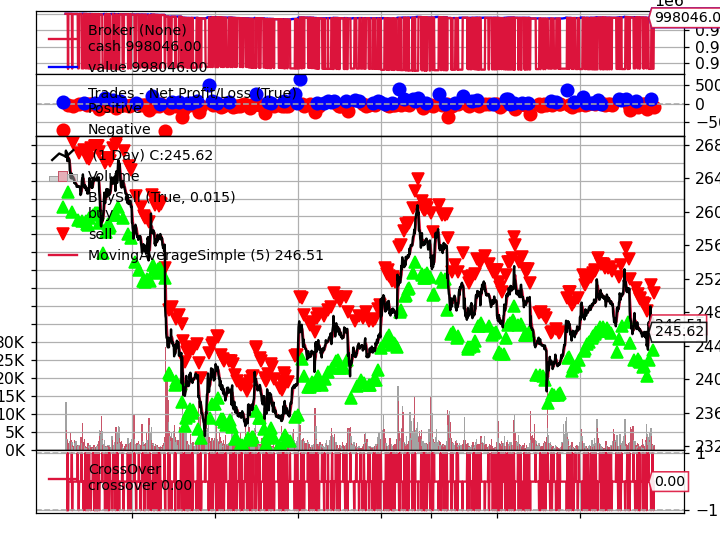

[[<Figure size 640x480 with 5 Axes>]]

In [38]:
import backtrader as bt
import akshare as ak



# 创建策略类
class SmaCross(bt.Strategy):
    # 定义参数
    params = dict(period=5  # 移动平均期数
                  )

    # 日志函数
    def log(self, txt, dt=None):
        '''日志函数'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 订单状态 submitted/accepted，无动作
            return

        # 订单完成
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行, %.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单 Canceled/Margin/Rejected')



    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f, 佣金 %.2f' %
                  (trade.pnl, trade.pnlcomm, trade.commission))

    def __init__(self):
        # 移动平均线指标
        self.move_average = bt.ind.MovingAverageSimple(
            self.data, period=self.params.period)

        # 交叉信号指标
        self.crossover = bt.ind.CrossOver(self.data, self.move_average)

    def next(self):

        if not self.position:  # 还没有仓位
            # 当日收盘价上穿5日均线，创建买单，买入100股
            if self.crossover > 0:
                self.log('创建买单')
                self.buy(size=100)
        # 有仓位，并且当日收盘价下破5日均线，创建卖单，卖出100股
        elif self.crossover < 0:
            self.log('创建卖单')
            self.sell(size=100)

##########################
# 主程序开始
#########################

# 创建大脑引擎对象
cerebro = bt.Cerebro()

# start_date = datetime(2018, 1, 1)  # 回测开始时间
# end_date = datetime(2020, 1, 1)  # 回测结束时间

 # 利用 AkShare 获取后复权数据
# stock_hfq_df = ak.stock_zh_a_daily(symbol="sh600000", adjust="hfq",start_date='20180101',end_date='20200101') 

# print(stock_hfq_df)

data = bt.feeds.PandasData(
 dataname=result2,
 datetime=0, # 日期所在列
 open=1, # 开盘价所在列
 high=2, # 最高价所在列
 low=3, # 最低价所在列
 close=4, # 收盘价价所在列
 volume=5, # 成交量所在列
 openinterest=-1, # 无未平仓量列.(openinterest是期货交易使用的)
)


cerebro.adddata(data)  # 将数据传入回测系统
cerebro.addstrategy(SmaCross)  # 将交易策略加载到回测系统中
cerebro.broker.setcash(1000000.0)  # 设置初始资金



cerebro.run()  # 运行
print('最终市值: %.2f' % cerebro.broker.getvalue())

cerebro.plot()  # 画图

In [8]:
import pandas as pd
from xtquant import xtdata
 
xtdata.download_history_data('90000967.SZO', period='tick')
data = xtdata.get_market_data(field_list=[], stock_list=['90000967.SZO'], period='tick', count=10)
 
df = pd.DataFrame(data['90000967.SZO'])
print(df.iloc[-1])

time                                   1664348400001
lastPrice                                        0.0
open                                             0.0
high                                             0.0
low                                              0.0
lastClose                                        0.0
amount                                         205.0
volume                                           205
pvolume                                            0
stockStatus                                        0
openInt                                         3517
lastSettlementPrice                              0.0
askPrice               [0.0, 0.0, 0.0, 0.001, 0.001]
bidPrice                   [0.0, 0.0, 0.0, 0.0, 0.0]
askVol                          [27, 31, 107, 5, 11]
bidVol                               [0, 0, 0, 0, 0]
settlementPrice                                  0.0
transactionNum                                    41
Name: 9, dtype: object


In [9]:
import datetime
df['datetime'] = df['time'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0))
print(df)

            time  lastPrice  open  high  low  lastClose  amount  volume  \
0  1664348353000        0.0   0.0   0.0  0.0        0.0   147.0     147   
1  1664348358000        0.0   0.0   0.0  0.0        0.0   147.0     147   
2  1664348365000        0.0   0.0   0.0  0.0        0.0   147.0     147   
3  1664348371000        0.0   0.0   0.0  0.0        0.0   147.0     147   
4  1664348377000        0.0   0.0   0.0  0.0        0.0   147.0     147   
5  1664348383000        0.0   0.0   0.0  0.0        0.0   147.0     147   
6  1664348385000        0.0   0.0   0.0  0.0        0.0   147.0     147   
7  1664348394000        0.0   0.0   0.0  0.0        0.0   147.0     147   
8  1664348400000        0.0   0.0   0.0  0.0        0.0   205.0     205   
9  1664348400001        0.0   0.0   0.0  0.0        0.0   205.0     205   

   pvolume  stockStatus  openInt  lastSettlementPrice  \
0        0            0     3464                  0.0   
1        0            0     3464                  0.0   
2  